In [ ]:
Было решено запустить АБ Тест, в котором в тестовой группе предлагается в два раза больше баллов 
    лояльности за покупку от 100 рублей. 

Эксперимент был проведен в нескольких торговых точках, которые в датасете представлены столбцом id_point. 
    Также в датасете есть информация о том, как долго клиент зарегистрирован у нас в программе лояльности.

Вам поступил запрос от отдела маркетинга:

- Рассчитать результаты эксперимента в целом и в отдельности по каждой торговой точке
- Вынести решение об эффективности воздействия Б по сравнению с воздействием А
- Сделать сегментацию пользователей с точки зрения длительности регистрации в программе лояльности

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import ttest_ind

In [2]:
sc = pd.read_csv('Dataset_AB_TEST.csv',sep=';')

In [3]:
sc.head()

,id_client,id_group,sum_pay,id_point,months_reg
0,1420218,test,3288.0,1199.0,8
1,1390221,control,1267.0,1182.0,11
2,1363404,control,4259.0,1178.0,2
3,1370042,test,7211.0,1179.0,3
4,1360376,control,760.0,1178.0,14


In [4]:
sc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10976 entries, 0 to 10975
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   id_client   10976 non-null  int64  
 1   id_group    10902 non-null  object 
 2   sum_pay     10849 non-null  float64
 3   id_point    10895 non-null  float64
 4   months_reg  10976 non-null  int64  
dtypes: float64(2), int64(2), object(1)
memory usage: 428.9+ KB


In [5]:
sc.isnull().sum()
# проверяем количество нулов. 

id_client       0
id_group       74
sum_pay       127
id_point       81
months_reg      0
dtype: int64

In [6]:
sc.describe()
# вывел статистику до удаления нулов

,id_client,sum_pay,id_point,months_reg
count,1.097600e+04,10849.000000,10895.000000,10976.000000
mean,1.373018e+06,3568.751037,1180.040385,4.717566
std,1.477359e+04,2927.164583,4.345107,3.185566
min,1.359000e+06,59.000000,1178.000000,0.000000
25%,1.361744e+06,1251.000000,1178.000000,2.000000
50%,1.370690e+06,3173.000000,1179.000000,4.000000
75%,1.373433e+06,5358.000000,1179.000000,7.000000
max,1.420345e+06,24797.000000,1199.000000,14.000000


In [7]:
# т.к. нулов не так много, то удаляем их
sc = sc.dropna()

In [8]:
sc.describe()
# и после удаления нулов, сравнить не сильно ли изменились данные. Мало ли удалил что то значительное

,id_client,sum_pay,id_point,months_reg
count,1.084000e+04,10840.000000,10840.000000,10840.000000
mean,1.372953e+06,3568.758026,1180.039760,4.693911
std,1.482036e+04,2927.273978,4.353995,3.174513
min,1.359000e+06,59.000000,1178.000000,0.000000
25%,1.361710e+06,1250.750000,1178.000000,2.000000
50%,1.370636e+06,3173.500000,1179.000000,4.000000
75%,1.373417e+06,5356.500000,1179.000000,6.000000
max,1.420345e+06,24797.000000,1199.000000,14.000000


In [10]:
np.percentile(sc['sum_pay'], np.arange (0, 100, 10))

array([  59. ,  410. ,  872.8, 1590. , 2329.6, 3173.5, 3934. , 4810. ,
       5967. , 7088.2])

In [18]:
sc['Decile'] = pd.qcut(sc['sum_pay'], 10, labels= False )
sc['Decile'] #примерно так считают квантили и децентили


0        5
1        2
2        6
3        9
4        1
        ..
10971    1
10972    7
10973    1
10974    2
10975    7
Name: Decile, Length: 10840, dtype: int64

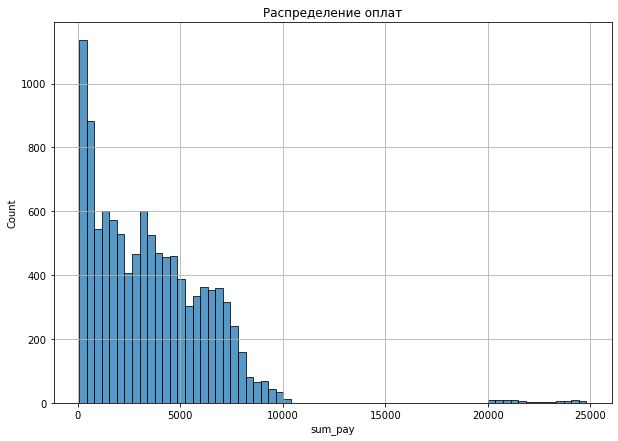

In [148]:
plt.figure(figsize=(10,7))
sns.histplot(sc['sum_pay'])
plt.title('Распределение оплат')
plt.grid()
plt.show()
# построим гистограмму распределение оплат

In [149]:
# видим что есть очень большие оплаты. Узнаем сколько их
sc[sc['sum_pay'] > 20000].count()
# 79 ....похоже на правду, не будет считать это какие то ошибками или вбросами

id_client     79
id_group      79
sum_pay       79
id_point      79
months_reg    79
dtype: int64

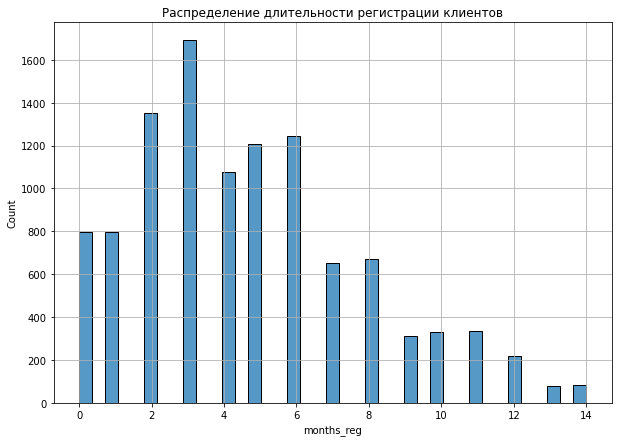

In [113]:
plt.figure(figsize=(10,7))
sns.histplot(sc['months_reg'])
plt.title('Распределение длительности регистрации клиентов')
plt.grid()
plt.show()
# построим гистограмму распределение длительности регистрации клиентов

In [151]:
sc['months_reg'].unique()
# количество уникальных месяцев

array([ 8, 11,  2,  3, 14,  5,  1,  0,  9, 12,  4,  6, 10,  7, 13],
      dtype=int64)

In [114]:
sc['id_group'] = sc.id_group.map({'control':0,'test':1})
sc.head()
# заменит object на значения

,id_client,id_group,sum_pay,id_point,months_reg
0,1420218,1,3288.0,1199.0,8
1,1390221,0,1267.0,1182.0,11
2,1363404,0,4259.0,1178.0,2
3,1370042,1,7211.0,1179.0,3
4,1360376,0,760.0,1178.0,14


In [115]:
# создадим нужные функции

In [116]:
def mann_whitney_func(x,y,alpha=0.05):
    s, p_value = stats.mannwhitneyu(x,y)
    
    if p_value < alpha:
        print('Распределения не равны')
    else: print('Распределения равны')
    
    return s, p_value
# маун увинтни тест говорит о разности распределений

In [117]:
def test_calc(x,y,alpha=0.05):
    s, p_value = stats.ttest_ind(x,y)
    
    if p_value < alpha:
        print('Распределения не равны')
    else: print('Распределения равны')
    
    return s, p_value
# t тест говорит о разнице средних

In [118]:
# создадим два df  с кажными результатами
sc_0 = sc.loc[sc['id_group'] == 0]
sc_1 = sc.loc[sc['id_group'] == 1]

In [119]:
sc_0['id_group'] = sc_0['id_group'].apply('float64')
sc_1['id_group'] = sc_1['id_group'].apply('float64')

C:\Users\pokus\AppData\Local\Temp\ipykernel_20428\592676822.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sc_0['id_group'] = sc_0['id_group'].apply('float64')
C:\Users\pokus\AppData\Local\Temp\ipykernel_20428\592676822.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sc_1['id_group'] = sc_1['id_group'].apply('float64')


In [120]:
sc_0.head()

,id_client,id_group,sum_pay,id_point,months_reg
1,1390221,0.0,1267.0,1182.0,11
2,1363404,0.0,4259.0,1178.0,2
4,1360376,0.0,760.0,1178.0,14
7,1373231,0.0,4008.0,1179.0,0
9,1373288,0.0,4109.0,1179.0,8


In [121]:
sc_1.head()

,id_client,id_group,sum_pay,id_point,months_reg
0,1420218,1.0,3288.0,1199.0,8
3,1370042,1.0,7211.0,1179.0,3
5,1371160,1.0,218.0,1179.0,5
6,1372110,1.0,1295.0,1179.0,1
8,1372555,1.0,4708.0,1179.0,9


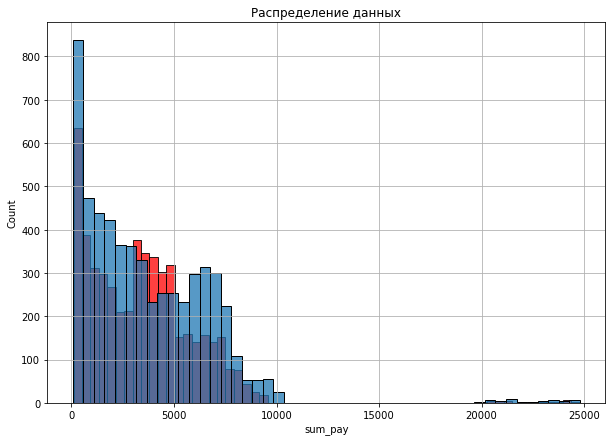

In [122]:
plt.figure(figsize=(10,7))
sns.histplot(sc_0['sum_pay'],color='red')
sns.histplot(sc_1['sum_pay'])
plt.title('Распределение данных')
plt.grid()
plt.show()
# строим гистограмму и видим что есть небольшие различия в распределении данных

In [123]:
# производим тестирование
mann_whitney_func(sc_0['sum_pay'], sc_1['sum_pay'])

Распределения не равны


(14316338.5, 0.03621040784028777)

In [124]:
test_calc(sc_0['sum_pay'], sc_1['sum_pay'])
# s  - значение статистического криметрия, р - p_valuo
# -3.9 это больше 1.96 значит Н1 побеждает Н0. Предварительно!

Распределения не равны


(-3.920008957178958, 8.90905813507598e-05)

In [125]:
# посчитаем основные статистические критерии. Не совсем понимаю зачем...но пусть будет
def statistical_analysis(data, q=[0.1,0.25,0.3,0.4,0.5,0.6,0.75,0.9]):

# мы передает DF
# функция для статистического анализа   
#  проверка на соответствие списку/кортежу
    
    if type(data) != tuple and type(data) != list:
        return print('Нужен список или кортеж!')
    
#  проверка длины ряда
    
    else:
        if len(data) <= 4:
            return print('Требуется более длинный ряд')
        
#  преобразование списка/кортежа в серию
 
        else:
            data = pd.Series(data)
            
#  создание датафрейма с квантильным анализом

            qs = np.quantile(data, q)
            qdf = pd.DataFrame(q, columns = ['quant_level'])
            qdf['quantile'] = qs
            
#  вывод требуемых статистических характеристик

            print("Среднее = ",data.mean())
            print("Дисперсия = ",data.var())
            print("Стандартное отклонение = ",data.std())
            
#  гистограмма с распределением данных

            #dr_corr = df[df[column]>80000.0]
            #sns.histplot(data=df_corr[column]
            sns.histplot(data)
    
#  закрытие функции, вывод датафрейма с квантильным анализом
    
            return qdf

Среднее =  3568.7580258302582
Дисперсия =  8568932.941996625
Стандартное отклонение =  2927.27397795229


,quant_level,quantile
0,0.10,410.00
1,0.25,1250.75
2,0.30,1590.00
3,0.40,2329.60
4,0.50,3173.50
5,0.60,3934.00
6,0.75,5356.50
7,0.90,7088.20


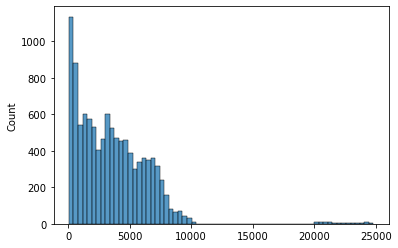

In [126]:
statistical_analysis(list(sc['sum_pay']))


In [127]:
# так же корреляция/Ковариация Пирсона и Спирмана 
def proxi_ranges(x,y,alpha=0.05):
    cov = np.cov(x,y)
    print(f'Ковариация: {round(cov[0][1],2)}')
    print(f'Дисперсия для метрики 1: {round(cov[0][0],2)}')
    print(f'Дисперсия для метрики 2: {round(cov[1][1],2)}')
    
    pearson_v, pearson_p = stats.pearsonr(x,y)
    spearman_v, spearman_p = stats.spearmanr(x,y)
    if pearson_p < alpha:
        if abs(pearson_v) < 0.3:
            person_corr = 'слабая'
        elif 0.3 <= abs(pearson_v) < 0.7:
            person_corr = 'средняя'
        else:
            person_corr = 'сильная'
        print(f'Корреляция Пирсона {person_corr}')    
    else:
        print('Корреляция Пирсона равна нулю')
    if spearman_p < alpha:
        if abs(spearman_v) < 0.3:
            spearman_corr = 'слабая'
        elif 0.3 <= abs(spearman_v) < 0.7:
            spearman_corr = 'средняя'
        else:
            spearman_corr = 'сильная'
        print(f'Корреляция Спирмана {spearman_corr}')    
    else:
        print('Корреляция Спирмана равна нулю'

SyntaxError: unexpected EOF while parsing (515757906.py, line 29)

In [128]:
proxi_ranges(sc['sum_pay'], sc['id_point'])

Ковариация: 1336.23
Дисперсия для метрики 1: 8568932.94
Дисперсия для метрики 2: 18.96
Корреляция Пирсона слабая
Корреляция Спирмана слабая


In [129]:
def p_v_point(x, y, alpha = 0.05):
    for i in x.unique():
        s, p = ttest_ind(sc[(x==i) &  (sc['id_group']==1)]['sum_pay'], sc[(x==i) & (sc['id_group']==0)]['sum_pay'])
        if p < alpha:
            print('Распределения не равны в point = ', i, 'и p =', p)

In [130]:
p_v_point(sc['id_point'], sc['months_reg'])

Распределения не равны в point =  1182.0 и p = 4.012995243252407e-15


In [131]:
# исключим из выборки point =  1182.0 и проверим какие будут результаты, распределения должны быть равны
sc_no_1182 = sc[sc['id_point'] != 1182.0] 

In [132]:
sc_no_1182['id_point'].unique()

array([1199., 1178., 1179., 1186., 1188.])

In [133]:
p_v_point(sc_no_1182['id_point'], sc_no_1182['months_reg'])
# при исключении 1182 распределени я оказались равны

In [138]:
# оценим наши выборки без 79 особо крупных платежей в точке 1188
sc_no_1188 = sc[sc['id_point'] != 1182.0] 
sc_no_1188.head()

,id_client,id_group,sum_pay,id_point,months_reg
0,1420218,1,3288.0,1199.0,8
2,1363404,0,4259.0,1178.0,2
3,1370042,1,7211.0,1179.0,3
4,1360376,0,760.0,1178.0,14
5,1371160,1,218.0,1179.0,5


In [139]:
p_v_point(sc_no_1188['id_point'], sc_no_1188['months_reg'])
# при исключении 1188 распределени я оказались равны

In [135]:
# создадим функцию для расчета и по point и по месяцам
def p_v_poimt_month(x, y, alpha = 0.05):
    for i in x.unique():
        for j in y.unique():
            #print(i,j)
            s, p = ttest_ind(sc[(x==i) & (y==j) & (sc['id_group']==1)]['sum_pay'], sc[(x==i) & (y==j) & (sc['id_group']==0)]['sum_pay'])
            if p < alpha:
                print('Распределения не равны в point = ', i, 'и months_reg =', j,  'и p =', p)

In [136]:
p_v_poimt_month(sc['id_point'], sc['months_reg'])

Распределения не равны в point =  1182.0 и months_reg = 8 и p = 0.01847579069699733
Распределения не равны в point =  1182.0 и months_reg = 11 и p = 0.03881564392359124
Распределения не равны в point =  1182.0 и months_reg = 2 и p = 1.8724407056800466e-06
Распределения не равны в point =  1182.0 и months_reg = 3 и p = 0.004680596478231153
Распределения не равны в point =  1182.0 и months_reg = 1 и p = 1.252060356647832e-07
Распределения не равны в point =  1182.0 и months_reg = 0 и p = 1.7673060146538122e-05
Распределения не равны в point =  1178.0 и months_reg = 8 и p = 1.3606457601984865e-05
Распределения не равны в point =  1178.0 и months_reg = 11 и p = 0.00037270654080624586
Распределения не равны в point =  1178.0 и months_reg = 2 и p = 3.077004111176186e-13
Распределения не равны в point =  1178.0 и months_reg = 3 и p = 2.5348650691222226e-11
Распределения не равны в point =  1178.0 и months_reg = 5 и p = 6.808742455668751e-07
Распределения не равны в point =  1178.0 и months_re

D:\Steam\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
D:\Steam\anaconda3\lib\site-packages\numpy\core\_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


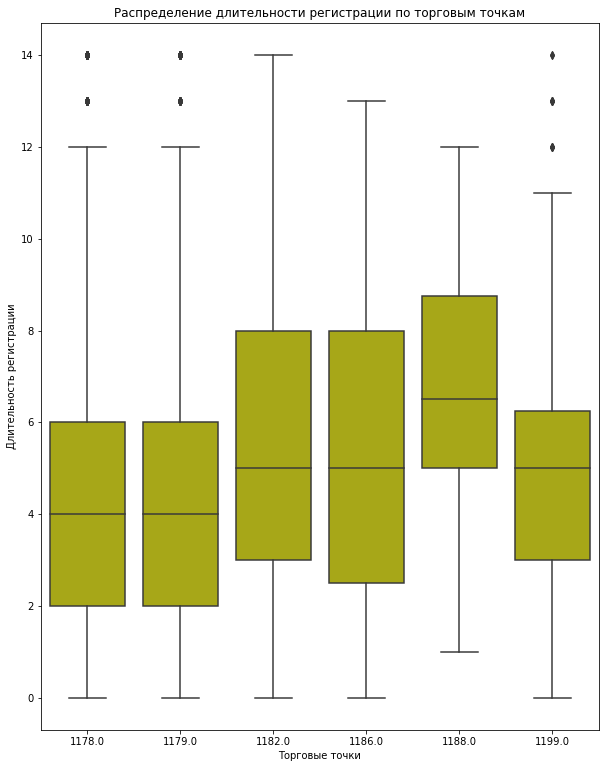

In [137]:
plt.figure(figsize=(10, 13)) 
plt.title('Распределение длительности регистрации по торговым точкам') 
sns.boxplot(x='id_point',
            y='months_reg',
            data=sc, 
            color='y')
plt.ylabel('Длительность регистрации') # Подпишем ось Y
plt.xlabel('Торговые точки') # Подпишем ось Y
plt.show()

In [87]:
sc_pivot = sc.groupby(['id_point','months_reg'])['sum_pay'].mean().reset_index()
sc_pivot

,id_point,months_reg,sum_pay
0,1178.0,0,835.197778
1,1178.0,1,889.103960
2,1178.0,2,1701.248109
3,1178.0,3,2049.777358
4,1178.0,4,3785.773333
...,...,...,...
77,1199.0,10,4671.625000
78,1199.0,11,6527.125000
79,1199.0,12,4622.400000
80,1199.0,13,3082.833333


In [88]:
sc_pivot = sc_pivot.pivot(index="id_point", 
                    columns="months_reg", 
                    values="sum_pay")

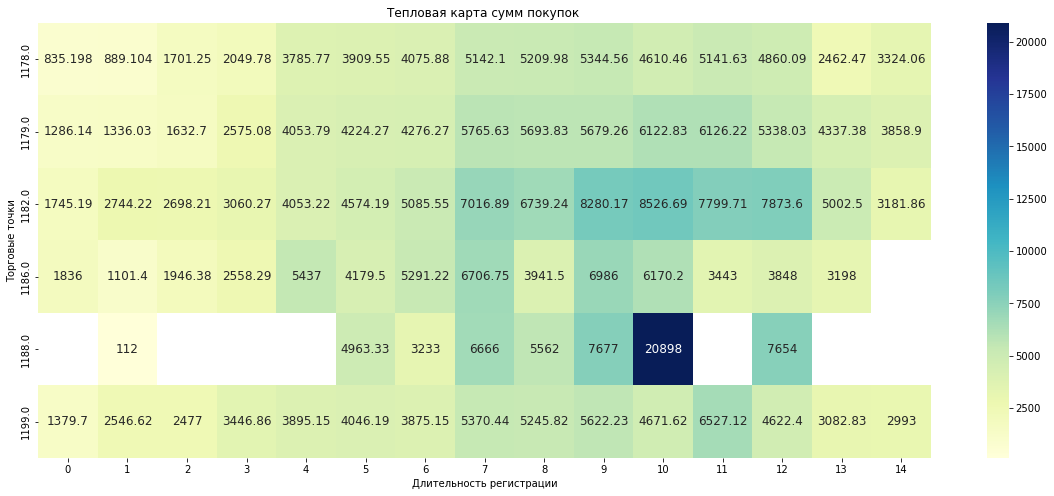

In [96]:

plt.figure(figsize=(20,8))
sns.heatmap(sc_pivot, 
            annot=True, 
            cmap="YlGnBu",
            fmt='g',
            annot_kws={'size':12})
plt.title("Тепловая карта сумм покупок ")
plt.ylabel("Торговые точки")
plt.xlabel("Длительность регистрации")
plt.show()

In [ ]:
#мы видим что наиболее результативна у нас точка 1182 и больше всего денег приносят клиенты с регистрацией от 7 до 12 месяцев

In [101]:
# т.к. видно большие вбросы по пункту 1188, проверим что там такое и найдем все те же 79 оплат, что были выявлены ранее
sc_1188 = sc[sc['id_point'] == 1182.0] 
sc_1188.head()

,id_client,id_group,sum_pay,id_point,months_reg
1,1390221,0,1267.0,1182.0,11
10,1391349,0,3975.0,1182.0,12
14,1390207,0,454.0,1182.0,1
19,1391351,1,7615.0,1182.0,6
23,1390990,0,399.0,1182.0,5


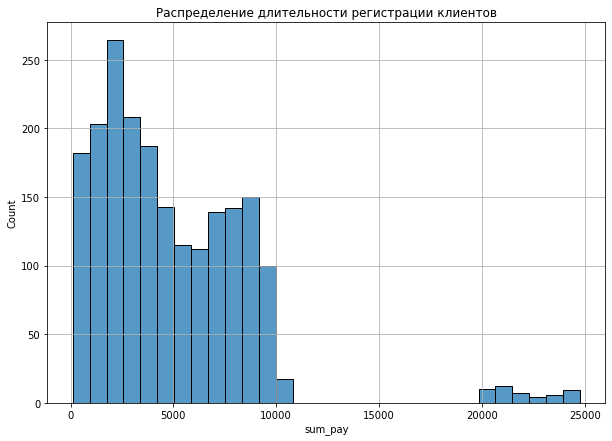

In [102]:
plt.figure(figsize=(10,7))
sns.histplot(sc_1188['sum_pay'])
plt.title('Распределение длительности регистрации клиентов')
plt.grid()
plt.show()

In [78]:
sc_col = ['id_point', 'months_reg', 'sum_pay']

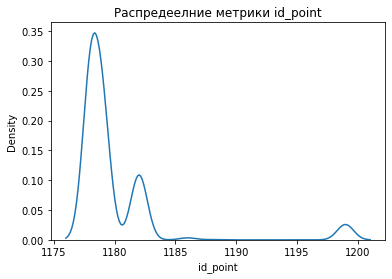

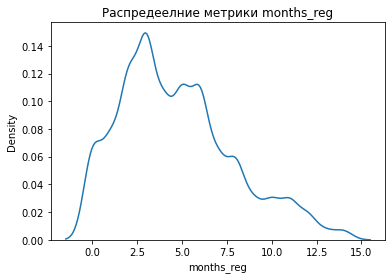

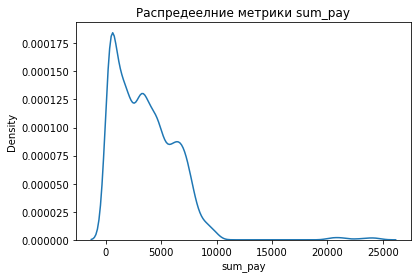

In [79]:
# цикл для построения графика
for col in sc_col:
    sns.kdeplot(sc[col])
    plt.title(f'Распредеелние метрики {col}')
    plt.show()